In [74]:
import os
import cv2 
import numpy as np


In [75]:
def list_images(basePath, validExts=(".jpg", ".jpeg"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

In [76]:
poissons = ['ange', 'clown','goldfish','lion','scalaire']
dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4}
db = []
label = []

In [77]:
for poisson in poissons:
    path = list_images('new_data/'+poisson)
    for image in path:
        im = cv2.imread(image)
        im = np.array(im)
        label.append(dict[poisson])
        db.append(im)


db = np.array(db)
label = np.array(label)

print(db.shape,label.shape)


(7501, 100, 100, 3) (7501,)


In [78]:
#One hot encoding des labels
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
label = label.reshape(len(label), 1)
label = onehot_encoder.fit_transform(label)
print(label.shape)

(7501, 5)


In [79]:
#normaliser les données
db=db.astype('float32')/255

In [80]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(db, label,test_size=0.3)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

In [81]:

from keras import utils, layers, models, optimizers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1,1),activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 141376)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                9048128   
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                      

In [82]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(xtrain,ytrain,batch_size=128,epochs=100,validation_data=(xtest,ytest))

Epoch 1/100


2023-01-05 21:39:55.141999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.3989 - acc: 0.4436

2023-01-05 21:40:05.356594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 12s 220ms/step - loss: 1.3989 - acc: 0.4436 - val_loss: 1.1014 - val_acc: 0.5940
Epoch 2/100
42/42 [==============================] - 8s 180ms/step - loss: 0.7431 - acc: 0.7389 - val_loss: 1.0689 - val_acc: 0.5971
Epoch 3/100
42/42 [==============================] - 8s 181ms/step - loss: 0.5498 - acc: 0.8053 - val_loss: 0.5917 - val_acc: 0.8059
Epoch 4/100
42/42 [==============================] - 8s 183ms/step - loss: 0.2982 - acc: 0.9061 - val_loss: 0.5852 - val_acc: 0.8041
Epoch 5/100
42/42 [==============================] - 8s 186ms/step - loss: 0.1852 - acc: 0.9499 - val_loss: 0.4366 - val_acc: 0.8485
Epoch 6/100
42/42 [==============================] - 7s 175ms/step - loss: 0.0841 - acc: 0.9815 - val_loss: 0.7809 - val_acc: 0.7810
Epoch 7/100
42/42 [==============================] - 8s 179ms/step - loss: 0.0648 - acc: 0.9848 - val_loss: 0.5046 - val_acc: 0.8530
Epoch 8/100
42/42 [==============================] - 7s 175ms/step - loss: 0.024

Text(0.5, 0, 'Epochs')

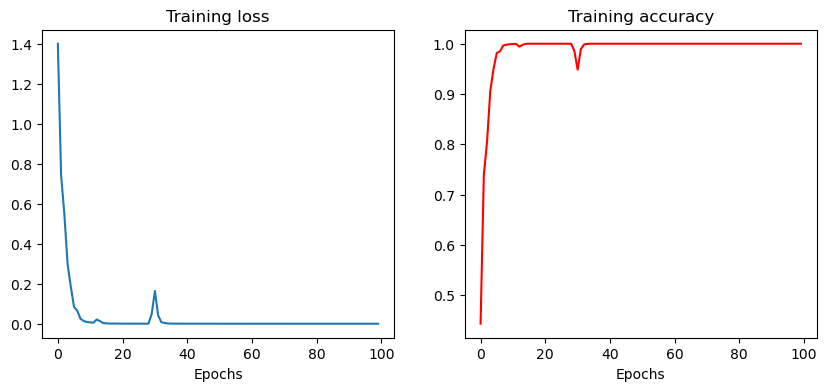

In [83]:
import matplotlib.pyplot as plt

f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(history.history['loss'])
ax1.set_title('Training loss')
ax1.set_xlabel('Epochs')

ax2.plot(history.history['acc'],'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Epochs')

Text(0.5, 0, 'Epochs')

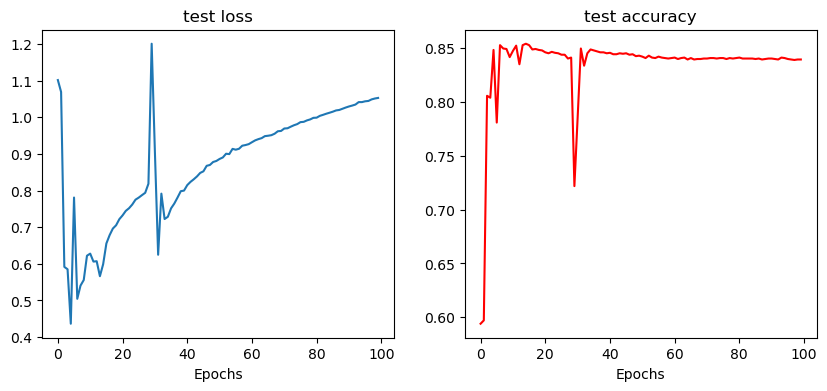

In [84]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(history.history['val_loss'])
ax1.set_title('test loss')
ax1.set_xlabel('Epochs')

ax2.plot(history.history['val_acc'],'r')
ax2.set_title('test accuracy')
ax2.set_xlabel('Epochs')

In [85]:
test_loss, test_acc = model.evaluate(xtest,ytest)
print('test_acc:', test_acc) #

71/71 [==============================] - 4s 56ms/step - loss: 1.0526 - acc: 0.8396
test_acc: 0.8396268486976624
